# This Program will find Active days using rainfll data for sst data (1982 onwards)

#### Written by - Chandrima Chakrabarty (chakrabartychandrima91@gmail.com)

import modules

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
from matplotlib.cm import get_cmap


Read .nc file

In [ ]:
ds = xr.open_dataset('rf_1901_2019.nc')

Selecting the central-India box

In [ ]:
ci_box = ds.sel(lon=slice(74,85),lat=slice(18,28)).mean(dim='lat').mean(dim='lon')

Convert to pandas dataframe

In [ ]:
df = pd.DataFrame(ci_box.rf.values,index=pd.to_datetime(ci_box.time.values),columns=['rain'])

Took only JJAS

In [ ]:
df_jjas = df[(df.index.month >=6) & (df.index.month <=9)]

Put the conditions-

1. Rainfall more than 9 mm/day

In [ ]:
actv_dy_t = df_jjas[(df_jjas.rain >= 9)].dropna()

2. Took consecutive >= 3 days

In [7]:
actv_dy = actv_dy_t.reset_index()
actv_dy.columns = ['date','rain']

In [8]:
actv_dy.date      = pd.to_datetime(actv_dy.date)
actv_dy['Newkey'] = actv_dy.date.diff().dt.days.ne(1).cumsum()
actv_dy 

,date,rain,Newkey
0,1901-07-05,10.035854,1
1,1901-07-10,14.666198,2
2,1901-07-11,10.813322,2
3,1901-07-18,10.497563,3
4,1901-07-19,9.440363,3
...,...,...,...
5199,2019-09-26,15.033700,1411
5200,2019-09-27,13.619778,1411
5201,2019-09-28,18.094391,1411
5202,2019-09-29,16.561506,1411


In [9]:
actv_dy           = actv_dy.groupby(['Newkey'])['date'].agg(['first','last','count'])
actv_dy          

,first,last,count
Newkey,,,
1,1901-07-05,1901-07-05,1
2,1901-07-10,1901-07-11,2
3,1901-07-18,1901-07-23,6
4,1901-07-25,1901-07-26,2
5,1901-07-28,1901-07-29,2
...,...,...,...
1407,2019-09-01,2019-09-02,2
1408,2019-09-04,2019-09-09,6
1409,2019-09-12,2019-09-14,3


In [10]:
actv_dy2 = actv_dy[actv_dy['count'] >= 3]

In [11]:
actv_dy2       = actv_dy2.reset_index()
actv_dy2.index = pd.to_datetime(actv_dy2['first'])

In [12]:
actv_dy2 = actv_dy2[actv_dy2.index.year >= 1982]

In [13]:
actv_dy2

,Newkey,first,last,count
first,,,,
1982-07-23,966,1982-07-23,1982-07-30,8
1982-08-06,968,1982-08-06,1982-08-09,4
1982-08-11,969,1982-08-11,1982-08-14,4
1982-08-16,970,1982-08-16,1982-08-24,9
1982-08-29,971,1982-08-29,1982-09-01,4
...,...,...,...,...
2019-08-13,1404,2019-08-13,2019-08-16,4
2019-08-24,1406,2019-08-24,2019-08-27,4
2019-09-04,1408,2019-09-04,2019-09-09,6


In [14]:
actv_day = np.array([])

for i in range(0,len(actv_dy2)):
    dt_arry   = list(pd.date_range(actv_dy2.iloc[i,1],actv_dy2.iloc[i,2]))
    #print(actv_dy2.iloc[i,3])
    actv_day = np.append(actv_day,dt_arry)

In [15]:
actv_day

array([Timestamp('1982-07-23 00:00:00', freq='D'),
       Timestamp('1982-07-24 00:00:00', freq='D'),
       Timestamp('1982-07-25 00:00:00', freq='D'), ...,
       Timestamp('2019-09-28 00:00:00', freq='D'),
       Timestamp('2019-09-29 00:00:00', freq='D'),
       Timestamp('2019-09-30 00:00:00', freq='D')], dtype=object)

In [16]:
%store actv_day

Stored 'actv_day' (ndarray)


In [17]:
active_rain = ds.sel(time=actv_day)

In [18]:
actv_day

array([Timestamp('1982-07-23 00:00:00', freq='D'),
       Timestamp('1982-07-24 00:00:00', freq='D'),
       Timestamp('1982-07-25 00:00:00', freq='D'), ...,
       Timestamp('2019-09-28 00:00:00', freq='D'),
       Timestamp('2019-09-29 00:00:00', freq='D'),
       Timestamp('2019-09-30 00:00:00', freq='D')], dtype=object)

/home/reji/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


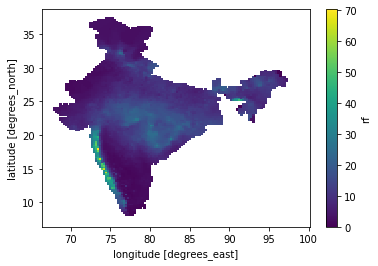

In [19]:
active_rain.mean(dim='time').rf.plot()


In [20]:
def common_plot(data,lon,lat,color='WhiteBlueGreenYellowRed',title='Default',levels=np.arange(20,200,10)):
    img_extent =[60, 110, 0, 40]
    ax.set_extent(img_extent, ccrs.PlateCarree())
    #cmap1 = nclcmaps.cmap(color)
    cmap1 = get_cmap('Reds')
    c = ax.contourf(lon, lat, data, extent=img_extent, cmap=cmap1
                ,levels=levels,extend='both',transform=ccrs.PlateCarree())

    plt.colorbar(c,pad=0.07,ax=ax,shrink=0.85,orientation='vertical')
    
    BORDER_ZORDER = 1110
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black', linestyle=":",zorder=BORDER_ZORDER,alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    ax.coastlines()
    ax.set_title(title,fontsize=20)

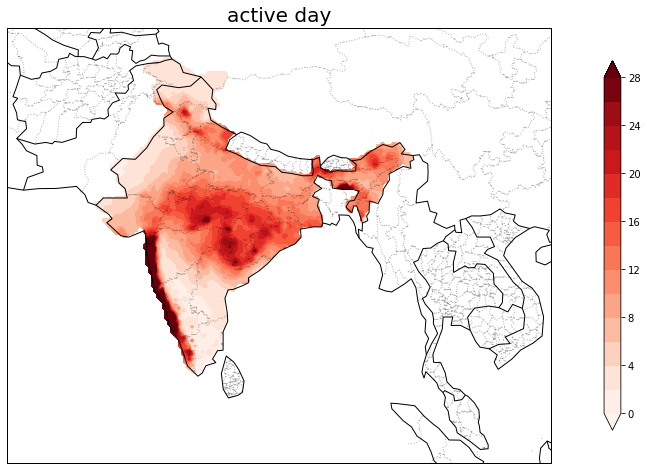

In [24]:
fig=plt.figure(figsize=[30,8])
ax = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
common_plot(lon=active_rain.lon,lat=active_rain.lat,data=active_rain.mean(dim='time').rf,
            color='WhiteBlueGreenYellowRed',title='active day',
            levels=np.arange(0,30,2))